In [1]:
using MGVInference
using Distributions
using Random
using ValueShapes
using LinearAlgebra
using Plots

In [2]:
polyfit_model = "../test/test_models/polyfit.jl"
open(polyfit_model, "r") do io
    map(println, readlines(io))
end
include(polyfit_model)

# This file is a part of MGVInference.jl, licensed under the MIT License (MIT).

using Distributions
using Random
using ValueShapes

_x1_grid = [Float64(i)/10 for i in 1:25]
_x2_grid = [Float64(i)/10 + 0.1 for i in 1:15]
_common_grid = sort(vcat(_x1_grid, _x2_grid))

function _mean(x_grid, p)
    p[1]*10 .+ p[2]*40 .* x_grid .+ p[3]*600 .* x_grid.^2 .+ p[4]*80 .* x_grid.^3
end

function model(p)
    dist1 = Product(Normal.(_mean(_x1_grid, p), p[5]^2*60))
    dist2 = Product(Normal.(_mean(_x2_grid, p), p[5]^2*60))
    NamedTupleDist(a=dist1,
                   b=dist2)
end

true_params =  [
 -0.3
 -1.5
 0.2
 -0.5
 0.3]

starting_point = [
  0.2
  0.5
  -0.1
  0.3
 -0.6
]

export model, true_params, starting_point


In [3]:
data = rand(model(true_params), 1)[1];

In [4]:
function _mean(x::Vector)
    _mean(_common_grid, x)
end

_mean (generic function with 2 methods)

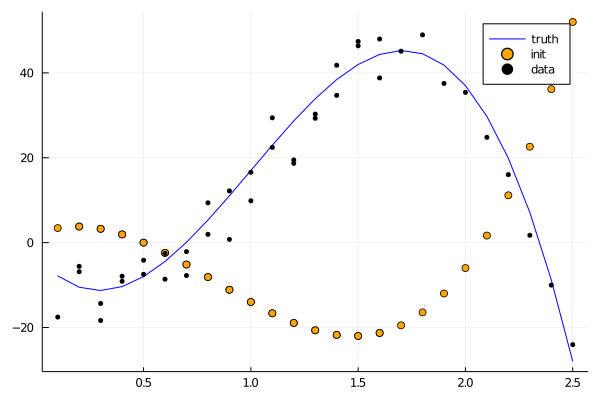

In [6]:
init_plots =() -> let
    truth = _mean(true_params)
    plot!(_common_grid, truth, markercolor=:blue, linecolor=:blue, label="truth")
    scatter!(_common_grid, _mean(starting_point), markercolor=:orange, label="init")
    scatter!(vcat(_x1_grid, _x2_grid), MGVInference.unshaped(data), markercolor=:black, markersize=3, label="data")
end
plot()
init_plots()

In [8]:
first_iteration = mgvi_kl_optimize_step(model, data, starting_point)

display(hcat(first_iteration, true_params))

5×2 Array{Float64,2}:
 -0.642859  -0.3
 -1.09381   -1.5
  0.164922   0.2
 -0.427679  -0.5
 -1.86348    0.3

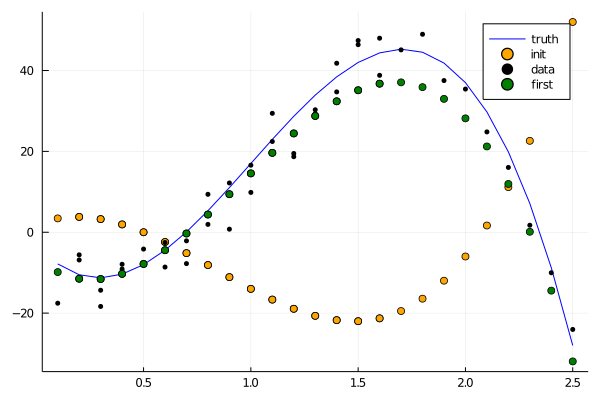

In [9]:
plot_iteration = (params, label) -> let
    #error_mat = mgvi_kl_errors(full_model, params)
    #display(error_mat)
    #errors = sqrt.(error_mat[diagind(error_mat)])
    #yerr = abs.(line(common_grid, params+errors) - line(common_grid, params-errors))
    #scatter!(common_grid, line(common_grid, params), markercolor=:green, label=label, yerr=yerr)
    scatter!(_common_grid, _mean(params), markercolor=:green, label=label)
end
    
plot()
init_plots()
plot_iteration(first_iteration, "first")

In [10]:
plot_iteration_light = (params, counter) -> let
    scatter!(_common_grid, _mean(params), markercolor=:green, markersize=3, markeralpha=2*atan(counter/18)/π, label=nothing)
end

#13 (generic function with 1 method)

5×2 Array{Float64,2}:
 -0.642859  -0.3
 -1.09381   -1.5
  0.164922   0.2
 -0.427679  -0.5
 -1.86348    0.3

5×2 Array{Float64,2}:
 -0.77061    -0.3
 -1.79013    -1.5
  0.0970204   0.2
 -0.0560734  -0.5
 -0.0184248   0.3

5×2 Array{Float64,2}:
 -0.507446  -0.3
 -1.41861   -1.5
  0.194      0.2
 -0.487066  -0.5
  0.281601   0.3

5×2 Array{Float64,2}:
 -0.389793  -0.3
 -1.52278   -1.5
  0.199986   0.2
 -0.496003  -0.5
  0.277523   0.3

5×2 Array{Float64,2}:
 -0.376284  -0.3
 -1.52432   -1.5
  0.198996   0.2
 -0.493958  -0.5
  0.253573   0.3

5×2 Array{Float64,2}:
 -0.541081  -0.3
 -1.39662   -1.5
  0.193433   0.2
 -0.486439  -0.5
  0.361641   0.3

5×2 Array{Float64,2}:
 -0.390828   -0.3
 -1.42505    -1.5
  0.190735    0.2
 -0.478237   -0.5
  0.0350358   0.3

5×2 Array{Float64,2}:
 -0.507443  -0.3
 -1.4186    -1.5
  0.194      0.2
 -0.487065  -0.5
 -0.281604   0.3

5×2 Array{Float64,2}:
 -0.210508  -0.3
 -1.69418   -1.5
  0.211135   0.2
 -0.520239  -0.5
 -0.276579   0.3

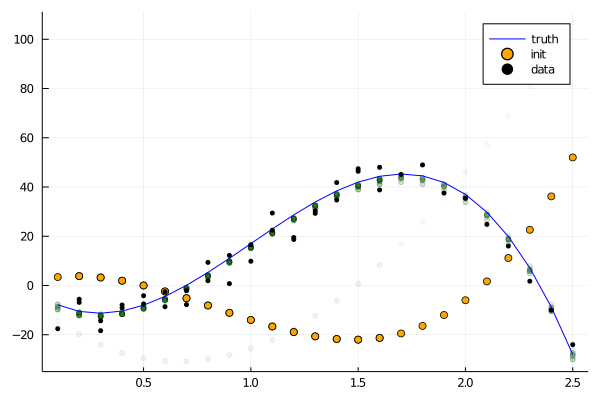

In [29]:
plt = scatter()
next_iteration = first_iteration
for i in 1:8
    display(hcat(next_iteration, true_params))
    next_iteration = mgvi_kl_optimize_step(model, data, next_iteration; residual_sampler=ImplicitResidualSampler)
    plot_iteration_light(next_iteration, i)
end
display(hcat(next_iteration, true_params))

init_plots()
display(plt)

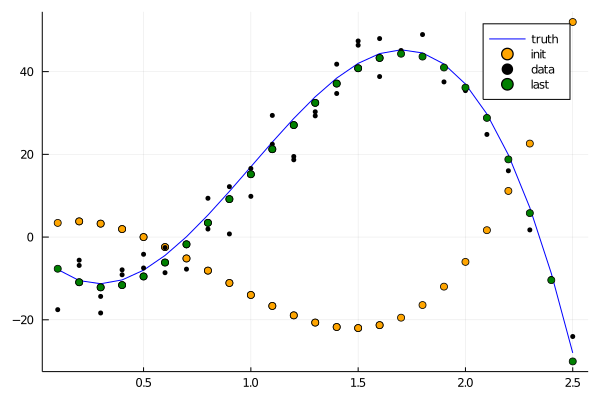

In [30]:
plot()
init_plots()
plot_iteration(next_iteration, "last")